In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

In [2]:
import tensorflow
print (tensorflow.__version__)

2.3.1


Training data shapes: X=(60000, 28, 28), y=(60000,)
Testing data shapes: X=(10000, 28, 28), y=(10000,)


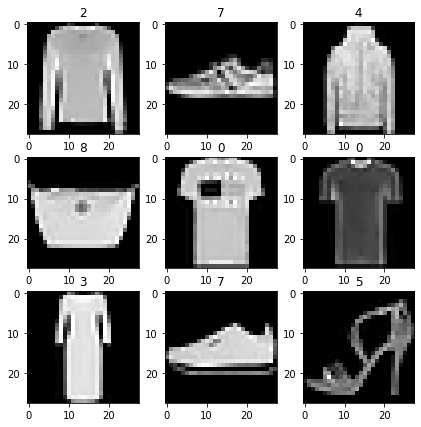

In [3]:
from tensorflow.keras.datasets import fashion_mnist, mnist

(trainX, trainY), (testX, testY) = fashion_mnist.load_data()

print('Training data shapes: X=%s, y=%s' % (trainX.shape, trainY.shape))
print('Testing data shapes: X=%s, y=%s' % (testX.shape, testY.shape))

plt.figure(figsize=(7, 7))
for j in range(9):
    i = np.random.randint(0, 10000)
    plt.subplot(330 + 1 + j)
    plt.imshow(trainX[i], cmap='gray')
    plt.title(trainY[i])
plt.show()

In [4]:
trainX = [image/255 for image in trainX]
testX = [image/255 for image in testX]

trainX = np.reshape(trainX, (60000, 28, 28, 1))
testX = np.reshape(testX, (10000, 28, 28, 1))

print (trainX.shape, testX.shape, trainY.shape, testY.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1) (60000,) (10000,)


# Generator Model (U-Net Like)

In [5]:
def encoder_layer(input_layer, filters, bn=True):
    x = tensorflow.keras.layers.Conv2D(filters, kernel_size=(4,4), strides=(2,2), padding='same')(input_layer)
    x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
    if bn:
        x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
    return x

def decoder_layer(input_layer, skip_input, filters):
    #x = tensorflow.keras.layers.UpSampling2D(size=2)(input_layer)
    x = tensorflow.keras.layers.Conv2DTranspose(filters, kernel_size=(4,4), strides=(2,2), padding='same')(input_layer)
    x = tensorflow.keras.layers.Activation('relu')(x)
    x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
    x = tensorflow.keras.layers.Concatenate()([x, skip_input])
    return x

In [7]:
source_image_input = tensorflow.keras.layers.Input(shape=(256, 256, 3))

e1 = encoder_layer(source_image_input, 64, bn=False)
e2 = encoder_layer(e1, 128)
e3 = encoder_layer(e2, 256)
e4 = encoder_layer(e3, 512)
e5 = encoder_layer(e4, 512)
e6 = encoder_layer(e5, 512)
e7 = encoder_layer(e6, 512)

bottle_neck = tensorflow.keras.layers.Conv2D(512, (4,4), strides=(2,2), padding='same')(e7)
b = tensorflow.keras.layers.Activation('relu')(bottle_neck)

d1 = decoder_layer(b, e7, 512)
d2 = decoder_layer(d1, e6, 512)
d3 = decoder_layer(d2, e5, 512)
d4 = decoder_layer(d3, e4, 512)
d5 = decoder_layer(d4, e3, 256)
d6 = decoder_layer(d5, e2, 128)
d7 = decoder_layer(d6, e1, 64)

decoded = tensorflow.keras.layers.Conv2DTranspose(3, kernel_size=(4,4), strides=(2,2), padding='same')(d7)
translated_image = tensorflow.keras.layers.Activation('tanh')(decoded)

generator_network = tensorflow.keras.models.Model(inputs=source_image_input, outputs=translated_image)
print (generator_network.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 3136        input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 128, 128, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 128)  131200      leaky_re_lu[0][0]                
_______________________________________________________________________________________

# Discriminator Network

In [42]:
def my_conv_layer(input_layer, filters, bn=True):
    x = tensorflow.keras.layers.Conv2D(filters, kernel_size=(4,4), strides=(2,2), padding='same')(input_layer)
    x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
    if bn:
        x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
    return x

In [43]:
source_image_input = tensorflow.keras.layers.Input(shape=(256, 256, 3))
target_image_input = tensorflow.keras.layers.Input(shape=(256, 256, 3))

combined = tensorflow.keras.layers.Concatenate(axis=-1)([source_image_input, target_image_input])

x = my_conv_layer(combined, 64, bn=False)
x = my_conv_layer(x, 128)
x = my_conv_layer(x, 256)
x = my_conv_layer(x, 512)

patch_features = tensorflow.keras.layers.Conv2D(1, kernel_size=(4,4), strides=(1,1), padding='same')(x)

discriminator_network = tensorflow.keras.models.Model(inputs=[source_image_input, target_image_input], outputs=patch_features)
print (discriminator_network.summary())

Model: "functional_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_34 (Concatenate)    (None, 256, 256, 6)  0           input_21[0][0]                   
                                                                 input_22[0][0]                   
__________________________________________________________________________________________________
conv2d_115 (Conv2D)             (None, 128, 128, 64) 6208        concatenate_34[0][0] 

In [44]:
adam_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_network.compile(loss='mse', optimizer=adam_optimizer, metrics=['accuracy'])

# GAN

In [46]:
discriminator_network.trainable=False

g_output = generator_network(source_image_input)
d_output = discriminator_network([source_image_input, g_output])

gan_model = tensorflow.keras.models.Model(inputs=source_image_input, outputs=[d_output, g_output])
gan_model.summary()

Model: "functional_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
functional_12 (Functional)      (None, 256, 256, 3)  54429315    input_21[0][0]                   
__________________________________________________________________________________________________
functional_14 (Functional)      (None, 16, 16, 1)    2771393     input_21[0][0]                   
                                                                 functional_12[1][0]              
Total params: 57,200,708
Trainable params: 54,419,459
Non-trainable params: 2,781,249
__________________________________________________________________________________________________


# Compiling Models

In [47]:
gan_model.compile(loss=['mse', 'mae'], optimizer=adam_optimizer, loss_weights=[1, 100])

# Define Data Generators

In [48]:
indices = [i for i in range(0, len(trainX))]

def get_random_noise(batch_size, noise_size):
    random_values = np.random.randn(batch_size*noise_size)
    random_noise_batch = np.reshape(random_values, (batch_size, noise_size))
    return random_noise_batch

def get_fake_samples(generator_network, batch_size, real_samples):
    fake_samples = generator_network.predict_on_batch(real_samples)
    return fake_samples

def get_real_samples(batch_size):
    random_indices = np.random.choice(indices, size=batch_size)
    real_source_images = trainX[np.array(random_indices),:]
    real_target_images = trainY[np.array(random_indices),:]
    return real_source_images, real_target_images


def show_generator_results(generator_network):
    real_source_images, real_target_images = get_real_samples(10)
    fake_samples = generator_network.predict_on_batch(real_source_images)

    plt.figure(figsize=(7, 7))
    for j in range(9):
        i = j
        plt.subplot(330 + 1 + j)
        plt.imshow(((fake_samples[i,:,:,-1])/2.0)+0.5, cmap='gray')
    plt.show()
    return

# Training GAN

In [49]:
epochs = 500
batch_size = 100
steps = 500

for i in range(0, epochs):
    if (i%10 == 0):
        op = show_generator_results(generator_network)
        #print (op)
    for j in range(steps):
        real_source_images, real_target_images = get_real_samples(batch_size=batch_size//2)
        fake_target_images = get_fake_samples(generator_network, batch_size//2, real_source_images)

        fake_patch = np.zeros((batch_size//2, 16, 16, 1))
        real_patch = np.ones((batch_size//2, 16, 16, 1))
        
        # Updating Discriminator weights
        discriminator_network.trainable=True
        loss_d1 = discriminator_network.train_on_batch([real_source_images, real_target_images], real_patch)
        loss_d2 = discriminator_network.train_on_batch([real_source_images, fake_target_images], fake_patch)
        
        loss_d = (np.add(loss_d1, loss_d2))/2.0
        
        
        real_source_images, real_target_images = get_real_samples(batch_size=batch_size)
        
        # Make the Discriminator belive that these are real samples and calculate loss to train the generator
        real_patch = np.ones((batch_size, 16, 16, 1))
        
        # Updating Generator weights
        discriminator_network.trainable=False
        loss_g, _, _ = gan_model.train_on_batch(real_source_images, [real_patch, real_target_images])
        
        if j%50 == 0:
            print ("Epoch:%.0f, Step:%.0f, D-Loss:%.3f, D-Acc:%.3f, G-Loss:%.3f"%(i,j,loss_d[0],loss_d[1]*100,loss_g))
            

IndexError: too many indices for array